# The Kaggle Rossmann Challenge: 
# Gradient Boosting vs. Deep Learning

<br><br><br>

## Ágoston Török, Krisztián Varga, Ádám Divák, Balázs Fehér PhD

# Who we are

## Ágoston

- Data scientist @Synetiq
- Junior researcher @MTA TTK Brain Imaging Centre
- Lecturer & phd candidate @ELTE 

## Balázs
- Data scientist @Deloitte | London from March 2016
- Data scientist @Infomatix | Budapest Nov 2015 - Feb 2016
- PhD in Cognitive Science | Saarbrücken 2011 - 2015

## Krisztián

- Research Engineer @Bell Labs, Nokia 


## Ádám
- CTO @Synetiq


# Why compete on Kaggle

- Fame and ~~Fortune~~
- It is fun
- It is learning

# Let's get started

In [1]:
%matplotlib inline
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w

import rossmann_helper_functions as rosshellfun #:)

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
w.filterwarnings("ignore", category=DeprecationWarning) 
w.filterwarnings("ignore", category=FutureWarning) 

Populating the interactive namespace from numpy and matplotlib
Rossmann Helper Functions imported


<h1>First look at the competition data</h1>
<br>
<table style="border:0" width="100%">
    <tr style="border:0">
        <td style="font-size: 18px; line-height: 1.5; border: 0; vertical-align: top;">
            <img src="csv1.png">
            <center>
            <b>Training data set<br>
            train.csv</b><br>
            <br>
            <div style="margin: auto; text-align: left; display: inline-block">
            - 3.5 years of sales data<br>
            - number of customers<br>
            - promotion activities<br>
            - store opening hours<br>
            - state / school holiday details<br>
            </div>
            </center>
        </td>

        <td style="font-size: 18px; line-height: 1.5; border: 0; vertical-align: top;">
            <img src="csv2.png">
            <center>
            <b>Store details<br>
            stores.csv</b><br>
            <br>
            <div style="margin: auto; text-align: left; display: inline-block">
             - store type code<br>
             - assortment type code<br>
             - long term promotions<br>
             - nearest competition<br>
             - locality unknown<br>
            </div>
            </center>
        </td>

        <td style="font-size: 18px; line-height: 1.5; border: 0; vertical-align: top;">
            <img src="csv3.png">
            <center>
            <b>Test data set<br>
            test.csv</b><br>
            <br>
            <div style="margin: auto; text-align: left; display: inline-block">
            - same as train.csv<br>
            - no sales and customer data<br>
            </div>
            </center>
        </td>
    </tr>
</table>

## Load the training, store and test data using pandas

In [2]:
types = {
    'CompetitionOpenSinceYear': np.dtype(int),
    'CompetitionOpenSinceMonth': np.dtype(int),
    'StateHoliday': np.dtype(str),
    'Promo2SinceWeek': np.dtype(int),
    'SchoolHoliday': np.dtype(int),
    'PromoInterval': np.dtype(str)
}
train = pd.read_csv("../train.csv", parse_dates=[2], dtype=types)
test  = pd.read_csv("../test.csv",  parse_dates=[3], dtype=types)
store = pd.read_csv("../store.csv")

train['Day']   = train.Date.dt.day
train['Month'] = train.Date.dt.month
train['Year']  = train.Date.dt.year

train.sort(['Store','Year','Month','Day'], inplace = True)

In [3]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
1016095,1,2,2013-01-01,0,0,0,0,a,1,1,1,2013
1014980,1,3,2013-01-02,5530,668,1,0,0,1,2,1,2013
1013865,1,4,2013-01-03,4327,578,1,0,0,1,3,1,2013
1012750,1,5,2013-01-04,4486,619,1,0,0,1,4,1,2013
1011635,1,6,2013-01-05,4997,635,1,0,0,1,5,1,2013


In [4]:
test.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


# Exploration and preparation

### - Explore the data

### - Drop bad values and impute missing ones

### - Feature widening

## Data exploration – days of week
### Sundays (where open) and Mondays dominate


<module 'matplotlib.pyplot' from 'c:\\python34\\lib\\site-packages\\matplotlib\\pyplot.py'>

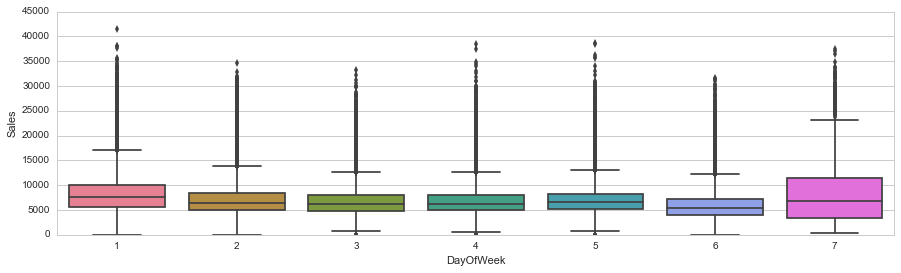

In [5]:
fig, (axis1) = plt.subplots(1, 1, figsize=(15,4))
train_plot = train[train["Open"] == 1]
sns.boxplot(x='DayOfWeek',y='Sales', data=train_plot.sort('DayOfWeek'), palette="husl", ax=axis1)
plt

(3000, 12500)

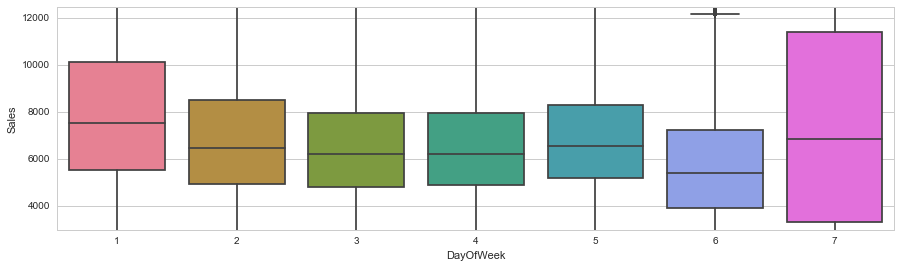

In [6]:
fig, (axis1) = plt.subplots(1, 1, figsize=(15,4))
train_plot = train[train["Open"] == 1]
sns.boxplot(x='DayOfWeek',y='Sales', data=train_plot.sort('DayOfWeek'), palette="husl", ax=axis1)
plt.ylim(ymax=12500, ymin=3000)

# Data exploration – days of month

### „Payday waves”, otherwise stable

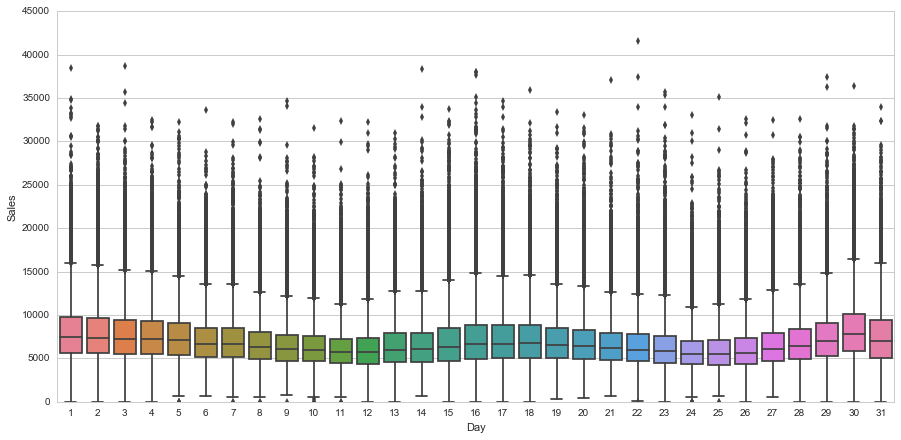

In [7]:
fig, (axis1) = plt.subplots(1, 1, figsize=(15,7))
sns.boxplot(x='Day',y='Sales', data=train_plot.sort('Day'), palette="husl", ax=axis1)

# Data exploration – Closing periods

### - Short closing periods (i.e. weekend) are visible on the day of week plot

### - But what about longer periods? (renovation, etc.)

In [8]:
for fest in ['a','b','c']:
    print('Max. consecutive day(s) for holiday type "%s" is %i' 
          % (fest, rosshellfun.longest_streak(train['StateHoliday'].values, fest)))

Max. consecutive day(s) for holiday type "a" is 1
Max. consecutive day(s) for holiday type "b" is 1
Max. consecutive day(s) for holiday type "c" is 2


In [9]:
print('Max. consecutive day(s) where a store was marked as closed is %i!' 
      % rosshellfun.longest_streak(train['Open'].values, 0))
print('Max. consecutive day(s) where a store was marked with zero sales is %i!' 
      % rosshellfun.longest_streak(train['Sales'].values, 0))

Max. consecutive day(s) where a store was marked as closed is 185!
Max. consecutive day(s) where a store was marked with zero sales is 185!


### Example store

(200, 20000)

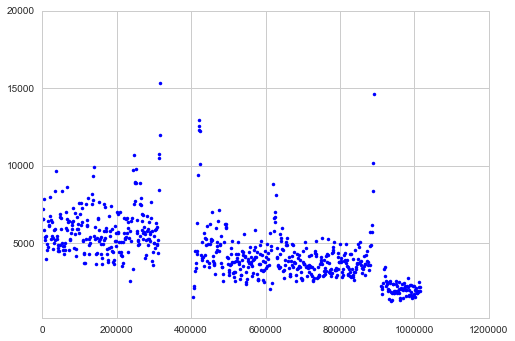

In [10]:
plt.plot(train.loc[train['Store'] == 708, 'Sales'], 'b.')
plt.ylim(ymax=20000, ymin=200)

## Add 'DaysLeft' and 'DaysAfter' columns

<h3>Sales in no. of days <span style="color: #0000AA">after opening</span> and <span style="color: #008800">before closing</span></h3>

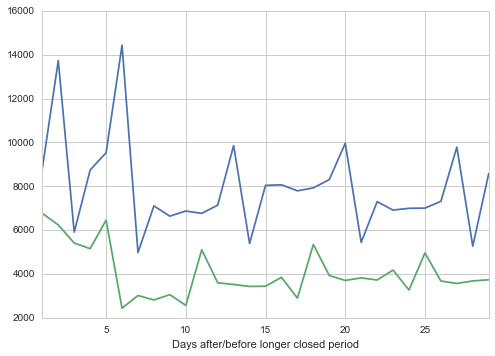

In [11]:
rosshellfun.addTimeToClose(train)
rosshellfun.addTimeToClose(test)
plt.xlabel('Days after/before longer closed period')

# Impute data & drop bad data

### - Check for missing values


### - Omit closed and zero-sales stores from the training (trivial prediction)

### - Impute missing values

In [12]:
print("There are %i missing Open/Close values in the TRAINING set." 
      % sum(np.isnan(train.loc[:,'Open'])))
print("There are %i missing Open/Close values in the TEST set."
      % sum(np.isnan(test.loc[:,'Open'])))

train = train[train["Open"] != 0]  
train = train[train["Sales"] > 0]

test.fillna(1, inplace=True)

There are 0 missing Open/Close values in the TRAINING set.
There are 11 missing Open/Close values in the TEST set.


# External data and feature widening

### Trivial join with store information

In [13]:
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

<h1>External sources</h1>
<br>
<table style="border:0" width="100%">
    <tr style="border:0">
        <td style="font-size: 22px; line-height: 1.5; border: 0; vertical-align: top;">
            <img src="weather200.png">
            <br><center>Weather</center>
        </td>
        <td style="font-size: 22px; line-height: 1.5; border: 0; vertical-align: top;">
            <img src="currency200.png">
            <br><center>Currency (EUR/USD)</center>
        </td>
        <td style="font-size: 22px; line-height: 1.5; border: 0; vertical-align: top;">
            <img src="search200.png">
            <br><center>Search popularity</center>
        </td>
    </tr>
</table>

## Weather
* WunderGround has an easy-to parse [REST interface](http://www.wunderground.com/history/airport/ETOU/2013/1/1/CustomHistory.html?dayend=31&monthend=12&yearend=2013&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1) and data for [many cities](http://www.wunderground.com/history/index.html?error=AMBIGUOUS&query=germany&day=15&month=11&year=2015&finalday=) in Germany
* Ratio threshold to determine overall likelihood of bad weather

## EUR-USD currency
* Quandl.com was also [kind to us](https://www.quandl.com/data/CURRFX/EURUSD-Currency-Exchange-Rates-EUR-vs-USD)

## Google search for „Rossmann”
* Google Trends was „[kind enough](https://www.google.com/trends/explore#q=Rossmann&geo=DE&date=1%2F2013%2036m&cmpt=q&tz=Etc%2FGMT-1)”
* Weekly precision

## Other ideas
* Population density (store location backtracking was not possible)
* Child births == diaper++ (we found no sufficient data sources)


In [14]:
# Load external data
ext_curr = rosshellfun.ext_load_currency_data(
    "../ExternalData/ext-currfx-eur-usd.csv") # EurUsdRate
ext_search = rosshellfun.ext_load_search_data(
    "../ExternalData/ext-rossmann-google-search-intensities-2013-2015.csv") # SearchRossmanGermany, SearchRossmanWorld
ext_weather = rosshellfun.ext_load_weather_data(
    "../ExternalData/ext-weather-events-germany.csv") # WeatherBad

# Join the existing data sets with the external data
train2 = train \
    .merge(ext_weather, on="Date") \
    .merge(ext_search, on="Date") \
    .merge(ext_curr, on="Date")
test2 = test \
    .merge(ext_weather, on="Date") \
    .merge(ext_search, on="Date") \
    .merge(ext_curr, on="Date")

print("Shape of vectors before/after joined external data:\nTrain", 
      train.shape, "=", train2.shape, "\nTest", test.shape, "=", test2.shape)

train = train2
test = test2

Shape of vectors before/after joined external data:
Train (844338, 23) = (844338, 27) 
Test (41088, 19) = (41088, 23)


## Feature widening - few more ideas

 - Map letters types to integer (a,b,c,... -> 1,2,3,...)
 - Add 'WeekOfYear'
 - Add 'CompetitionOpen' (nearest in months)
 - Add 'IsPromoMonth'

In [15]:
train = rosshellfun.build_features(train)
test = rosshellfun.build_features(test)

# Where are we now

In [16]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,DaysLeft,DaysAfter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeatherBad,SearchRossmanGermany,SearchRossmanWorld,EurUsdRate,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,2,2013-01-02,5530,668,1,0,0,1,2,1,2013,0,0,3,1,1270,9,2008,0,0,0,,0.746032,69,74,1.32214,1,52,0.00,0
1,2,2,2013-01-02,4422,650,1,0,0,1,2,1,2013,0,0,1,1,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",0.746032,69,74,1.32214,1,62,33.00,1
2,3,2,2013-01-02,6823,805,1,0,0,1,2,1,2013,0,0,1,1,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",0.746032,69,74,1.32214,1,73,20.75,1
3,4,2,2013-01-02,9941,1429,1,0,0,1,2,1,2013,0,0,3,3,620,9,2009,0,0,0,,0.746032,69,74,1.32214,1,40,0.00,0
4,5,2,2013-01-02,4253,577,1,0,0,1,2,1,2013,0,0,1,1,29910,4,2015,0,0,0,,0.746032,69,74,1.32214,1,-27,0.00,0


In [17]:
test.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,DaysLeft,DaysAfter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeatherBad,SearchRossmanGermany,SearchRossmanWorld,EurUsdRate,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,1,3,2015-09-17,1,1,0,0,0,0,3,1,1270,9,2008,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,84,0,0
1,2,3,3,2015-09-17,1,1,0,0,0,0,1,1,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",0.945763,75,66,1.13029,2015,9,17,38,105,54,0
2,3,7,3,2015-09-17,1,1,0,0,0,0,1,3,24000,4,2013,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,29,0,0
3,4,8,3,2015-09-17,1,1,0,0,0,0,1,1,7520,10,2014,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,11,0,0
4,5,9,3,2015-09-17,1,1,0,0,0,0,1,3,2030,8,2000,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,181,0,0


# Creating store categories based on sales similarity

- We have 1000+ stores
- It is reasonable to assume that the covariation is large
- It is reasonable to assume that there are similar stores (store type group)
- This is a posteriori grouping (We had storetype already in the data)
- We used hierarchical clustering

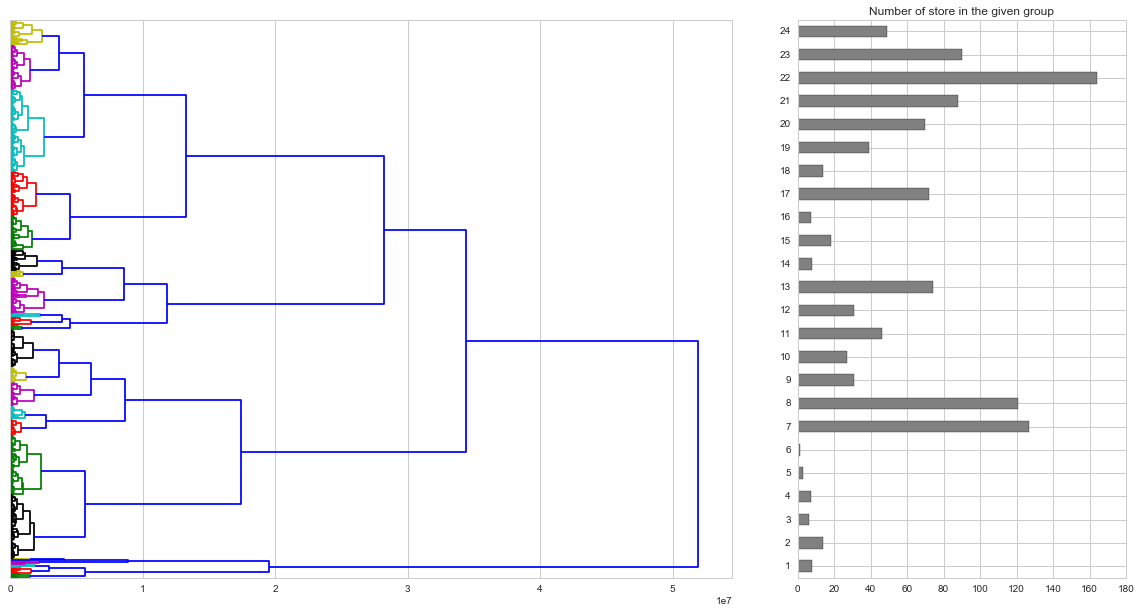

In [18]:
table = pd.pivot_table(train.loc[:,['Date','Sales','Store']],index = ['Date'], columns = ['Store'], values = ['Sales'] )

store_type_labels = rosshellfun.cluster_all_stores(table, cut_thresh = 0.05, method = 'ward')
# ward's method focuses on variance and not distance itself

# Let's check if everything is added correctly

- This is again a crucial step
- _'Pandas eat only indexes'_

![pandas](http://cdn.phys.org/newman/gfx/news/hires/2013/giantpandase.jpg)

In [19]:
# add store_type_labels to training and test
train = pd.merge(train, pd.DataFrame([store_type_labels,table.columns.get_level_values(1)],
                             columns = table.columns.get_level_values(1), 
                             index = ['StoreCluster','Store'] ).T, on='Store')
test = pd.merge(test, pd.DataFrame([store_type_labels,table.columns.get_level_values(1)],
                             columns = table.columns.get_level_values(1), 
                             index = ['StoreCluster','Store'] ).T, on='Store')

In [20]:
train.loc[:,['Store','StoreCluster']].drop_duplicates(inplace = False).sort('Store').head(10)

,Store,StoreCluster
0,1,8
781,2,8
1565,3,22
2344,4,17
3128,5,8
3907,6,7
4687,7,21
5473,8,7
6257,9,22
7036,10,7


In [21]:
test.loc[:,['Store','StoreCluster']].drop_duplicates(inplace = False).sort('Store').head(10)

,Store,StoreCluster
0,1,8
48,3,22
96,7,21
144,8,7
192,9,22
240,10,7
288,11,21
336,12,20
384,13,13
432,14,7


# Create dummy columns

- Categorical data is handled as dummy columns
- At this point we create a validation set 

In [22]:
#create dummy columns function creates dummy columns where values are value+_+columns name
train = rosshellfun.create_dummy_columns(train, ['StoreCluster','DayOfWeek','DaysLeft','DaysAfter'])
test = rosshellfun.create_dummy_columns(test, ['StoreCluster','DayOfWeek','DaysLeft','DaysAfter'])

In [23]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,DaysLeft,DaysAfter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeatherBad,SearchRossmanGermany,SearchRossmanWorld,EurUsdRate,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,StoreCluster,10_StoreCluster,11_StoreCluster,12_StoreCluster,13_StoreCluster,14_StoreCluster,15_StoreCluster,16_StoreCluster,17_StoreCluster,18_StoreCluster,19_StoreCluster,1_StoreCluster,20_StoreCluster,21_StoreCluster,22_StoreCluster,23_StoreCluster,24_StoreCluster,2_StoreCluster,3_StoreCluster,4_StoreCluster,5_StoreCluster,6_StoreCluster,7_StoreCluster,8_StoreCluster,9_StoreCluster,0_DayOfWeek,1_DayOfWeek,2_DayOfWeek,3_DayOfWeek,4_DayOfWeek,5_DayOfWeek,6_DayOfWeek,0_DaysLeft,1_DaysLeft,2_DaysLeft,3_DaysLeft,4_DaysLeft,5_DaysLeft,6_DaysLeft,0_DaysAfter,1_DaysAfter,2_DaysAfter,3_DaysAfter,4_DaysAfter,5_DaysAfter,6_DaysAfter
0,1,2_DayOfWeek,2013-01-02,5530,668,1,0,0,1,2,1,2013,0_DaysLeft,0_DaysAfter,3,1,1270,9,2008,0,0,0,,0.746032,69,74,1.32214,1,52,0,0,8_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,3_DayOfWeek,2013-01-03,4327,578,1,0,0,1,3,1,2013,0_DaysLeft,0_DaysAfter,3,1,1270,9,2008,0,0,0,,0.980159,69,74,1.31698,1,52,0,0,8_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,4_DayOfWeek,2013-01-04,4486,619,1,0,0,1,4,1,2013,0_DaysLeft,0_DaysAfter,3,1,1270,9,2008,0,0,0,,0.835294,69,74,1.30743,1,52,0,0,8_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,5_DayOfWeek,2013-01-05,4997,635,1,0,0,1,5,1,2013,0_DaysLeft,0_DaysAfter,3,1,1270,9,2008,0,0,0,,0.658333,69,74,1.30743,1,52,0,0,8_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0_DayOfWeek,2013-01-07,7176,785,1,1,0,1,7,1,2013,0_DaysLeft,0_DaysAfter,3,1,1270,9,2008,0,0,0,,0.392996,63,59,1.30526,2,52,0,0,8_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [24]:
# note Id is not sorted now
test = test.sort('Id')
test.head(5) 

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,DaysLeft,DaysAfter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeatherBad,SearchRossmanGermany,SearchRossmanWorld,EurUsdRate,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,StoreCluster,10_StoreCluster,11_StoreCluster,12_StoreCluster,13_StoreCluster,14_StoreCluster,15_StoreCluster,16_StoreCluster,17_StoreCluster,18_StoreCluster,19_StoreCluster,1_StoreCluster,20_StoreCluster,21_StoreCluster,22_StoreCluster,23_StoreCluster,24_StoreCluster,2_StoreCluster,3_StoreCluster,4_StoreCluster,5_StoreCluster,6_StoreCluster,7_StoreCluster,8_StoreCluster,9_StoreCluster,0_DayOfWeek,1_DayOfWeek,2_DayOfWeek,3_DayOfWeek,4_DayOfWeek,5_DayOfWeek,6_DayOfWeek,0_DaysLeft,1_DaysLeft,2_DaysLeft,3_DaysLeft,4_DaysLeft,5_DaysLeft,6_DaysLeft,0_DaysAfter,1_DaysAfter,2_DaysAfter,3_DaysAfter,4_DaysAfter,5_DaysAfter,6_DaysAfter
0,1,1,3_DayOfWeek,2015-09-17,1,1,0,0,0_DaysLeft,0_DaysAfter,3,1,1270,9,2008,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,84,0,0,8_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
48,2,3,3_DayOfWeek,2015-09-17,1,1,0,0,0_DaysLeft,0_DaysAfter,1,1,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",0.945763,75,66,1.13029,2015,9,17,38,105,54,0,22_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
96,3,7,3_DayOfWeek,2015-09-17,1,1,0,0,0_DaysLeft,0_DaysAfter,1,3,24000,4,2013,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,29,0,0,21_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
144,4,8,3_DayOfWeek,2015-09-17,1,1,0,0,0_DaysLeft,0_DaysAfter,1,1,7520,10,2014,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,11,0,0,7_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
192,5,9,3_DayOfWeek,2015-09-17,1,1,0,0,0_DaysLeft,0_DaysAfter,1,3,2030,8,2000,0,0,0,,0.945763,75,66,1.13029,2015,9,17,38,181,0,0,22_StoreCluster,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [25]:
# set up training features 

# from this we have to remove the original categorical and the string columns 
# AND the customers column that is not available in the test
# Gert predicted the customers also and used that to further help his prediction on the sales
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

features = train.select_dtypes(include=numerics).columns.values.tolist()
features.remove('Customers')
features.remove('Store') # categorical but is numeric
features.remove('Sales') # Of course let's remove the outcome
print(features)

['Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Day', 'Month', 'Year', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'WeatherBad', 'SearchRossmanGermany', 'SearchRossmanWorld', 'EurUsdRate', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth', '10_StoreCluster', '11_StoreCluster', '12_StoreCluster', '13_StoreCluster', '14_StoreCluster', '15_StoreCluster', '16_StoreCluster', '17_StoreCluster', '18_StoreCluster', '19_StoreCluster', '1_StoreCluster', '20_StoreCluster', '21_StoreCluster', '22_StoreCluster', '23_StoreCluster', '24_StoreCluster', '2_StoreCluster', '3_StoreCluster', '4_StoreCluster', '5_StoreCluster', '6_StoreCluster', '7_StoreCluster', '8_StoreCluster', '9_StoreCluster', '0_DayOfWeek', '1_DayOfWeek', '2_DayOfWeek', '3_DayOfWeek', '4_DayOfWeek', '5_DayOfWeek', '6_DayOfWeek', '0_DaysLeft', '1_DaysLeft', '2_DaysLeft', '3_DaysLeft', '4_DaysLeft', '5_DaysLeft'

In [26]:
from sklearn.cross_validation import train_test_split

# create test set
X = train.loc[:,features]
y = train.loc[:,'Sales']
train_base_x, train_validation_x, train_base_y, train_validation_y = train_test_split( X, y, test_size = 0.2 )

# Note Gert here did not randomly chose the hold out set but 
# he chose consecutive days

# Models

# What models have we tried?

- Linear regression, Ridge, Elasticnet, SVM etc. (we are not going to talk about these)
- Trees, forests (we are not going to talk about these either)
- Gradient Boosting (scikit)
- Neural networks (keras + theano)

# Gradient boosting

**Gradient boosting is the Holy Grail of several machine learning problems today**
- Almost every winning solution on Kaggle used it
    
**Gradient boosting is practically a huge ensemble of decision trees**
- The term _gradient_ refers to gradient descent
- Each tree is a step on the gradient
- Adds weight to training examples
- Learning rate ~ number of trees
    
**Strong regularization: **
- Control model complexity:
   - tree size and structure
- Add randomness to the training
   - subset of features, subset of samples etc.

*The difference between scikit GBM and XGBoost is... well actually as far as I see XGBoost gives you a little more option in logistic regression problems (e.g. max delta step)*

# Why gradient boosting

1. Handles well features of different scales
2. Support different loss functions
3. Can handle complex feature interactions and patterns

However:
1. Slow to train
2. Often comes as a black box

# How it works

The objective function consists of the sum of the Loss and Regularization parameter ($\Omega$). So:

$$Objective(\Theta) = Loss(\Theta) + \Omega(\Theta)$$

Where $\Theta$ is the parameter set to be defined.
The loss function that we used was 

$$\begin{align}
Loss(\Theta) = \left\{ \begin{array}{cl}
\frac{1}{2} \left[y-\hat{y}\right]^2 & \text{for }|y-\hat{y}| \le \alpha, \\
\alpha \left(|y-\hat{y}|-\alpha/2\right) & \text{for }|y-\hat{y}| \gt \alpha
\end{array}\right.
\end{align} $$

Where $\alpha$ was equal to $Q(.56)$ (that is ~median). This loss function applies squared loss for small residuals, but absolute loss for larger. Could be better then squared loss, when outliers would pull the squared loss from optimum. 

Huber, P. J. (1964). Robust estimation of a location parameter. The Annals of Mathematical Statistics, 35(1), 73-101.

# The hyperparameters

There are several parameters to set (both for the loss and for the regularization)
- One can use grid search or random search for the parameter tuning
- Or the available parameters on the forum and only finetune them (i.e. Gert)

![RSvsGS](http://blog.kaggle.com/wp-content/uploads/2015/07/scikitlearn8.jpeg)

Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. The Journal of Machine Learning Research, 13(1), 281-305.
ISO 690	

In [27]:
import random
from sklearn.grid_search import RandomizedSearchCV
from sklearn import ensemble
from scipy.stats import uniform, randint

# it is not necessary to search the parameters using the complete training set
training_subset = random.sample(range(len(train_base_x)),800) # this is intentionnaly so low it was 80000 in the competition
train_sample_x = train_base_x.iloc[training_subset,]
train_sample_y = train_base_y.iloc[training_subset,]

# note, this is not the whole parameter set of scikit (neither of XGBoost)
parameters = { 'learning_rate': uniform(), #0.426348401220647
               'max_depth' : [4, None], # None
               'min_samples_leaf' : randint(10, 100), #45
               'loss' : ['ls', 'lad', 'huber', 'quantile'], #'huber'
               'subsample' : uniform(), #0.7675104474139473
               'alpha': uniform()} #0.560116434370429

model = ensemble.GradientBoostingRegressor(n_estimators = 100, verbose = 0)

params_found = RandomizedSearchCV(model, param_distributions = parameters,
                               n_iter = 100, n_jobs = -1).fit(train_sample_x,train_sample_y)
params_found.best_params_

{'alpha': 0.1488202120136839,
 'learning_rate': 0.3114262700288696,
 'loss': 'ls',
 'max_depth': 4,
 'min_samples_leaf': 11,
 'subsample': 0.9627646211439049}

# Training and fitting of gradient boost model

In [28]:
model = ensemble.GradientBoostingRegressor(n_estimators = 100, verbose = 100, # in the challenge we used 3000 estimators
                                               learning_rate = params_found.best_params_['learning_rate'],
                                               loss = params_found.best_params_['loss'],
                                               max_depth = params_found.best_params_['max_depth'],
                                               min_samples_leaf = params_found.best_params_['min_samples_leaf'],
                                               subsample = params_found.best_params_['subsample'])

model = model.fit(train_base_x,train_base_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1     7924886.3356     1694369.7223            9.25m
         2     6854009.4164     1132722.4515           10.39m
         3     6045046.3758      802708.0835            9.75m
         4     5306670.7300      737789.4309            9.05m
         5     4794341.1294      521248.8958            8.37m
         6     4349407.7204      424369.9625            8.30m
         7     3993613.6836      352966.2646            8.08m
         8     3732460.8015      262263.7742            7.71m
         9     3458674.5739      267828.3985            7.48m
        10     3214343.8622      257118.6627            7.31m
        11     3022715.9556      189443.5004            7.30m
        12     2844473.4652      170463.1538            7.16m
        13     2711873.5502      144630.4449            6.92m
        14     2599217.1565      117704.8078            6.74m
        15     2484636.6463      118964.8835            6.75m
       

Saving model as 02_25_2016_18hrs05mins_0.226071770056.pkl


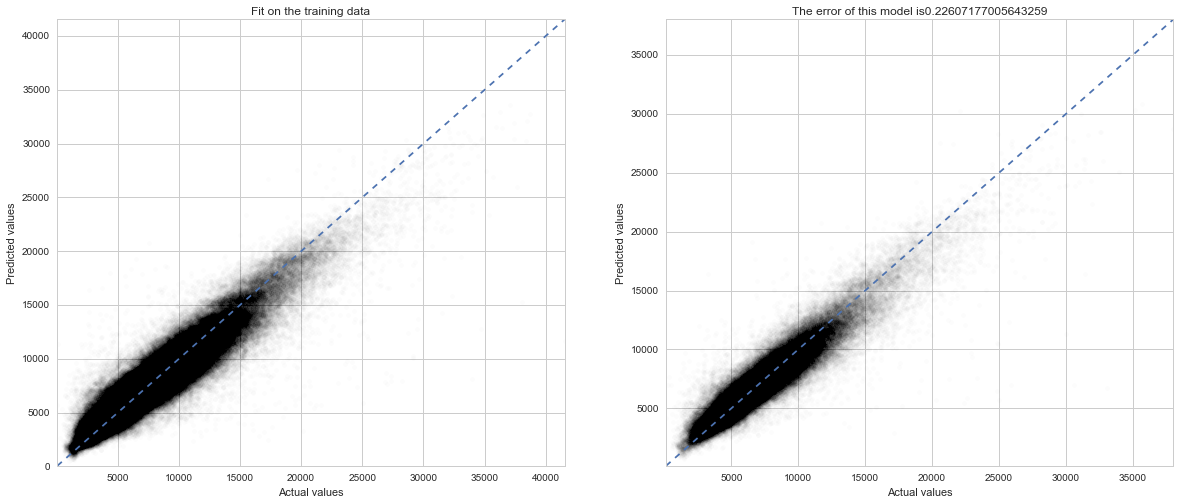

In [29]:
# Let's see how the model performed
rosshellfun.plot_results(model, train_base_x, train_validation_x, 
                         train_base_y, train_validation_y, savemodel = True)

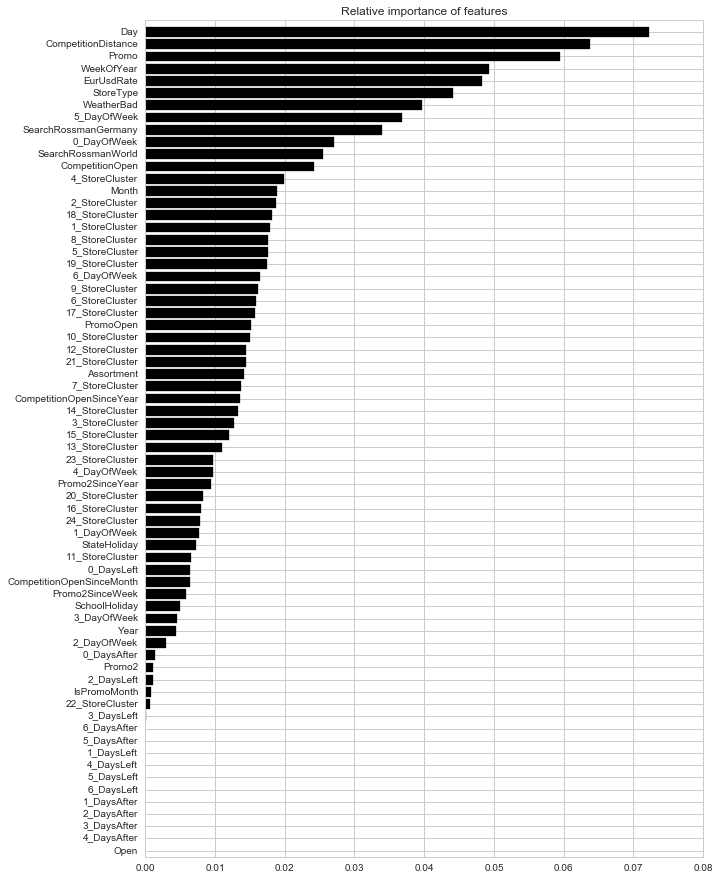

In [30]:
# let's see the relative importance of features
rosshellfun.plot_feature_importances(model, features)

# Summary of the gradient boosting

- It is a good, transparent (at least we think), realiable solution for regression
- This model was not able to compete with the highest ranked models 
    - Reason is that normally they used additional steps (such as Customers number prediction)
    - We made a mistake that took a long time to find: the dummy columns for the daysofweek were converted at some point to float, and so this feature was not included in the prediction

In [31]:
test['Sales'] = model.predict(test.loc[:,features])
test.loc[test['Open'] == 0,'Sales'] = 0
test.loc[:,['Id','Sales']].set_index('Id',drop = True).to_csv('submission_gbrt.csv')

# Neural Networks and Deep Learning


![RSvsGS](http://cs231n.github.io/assets/nn1/neuron.png)


![RSvsGS](http://cs231n.github.io/assets/nn1/neuron_model.jpeg)


![RSvsGS](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

![RSvsGS](http://image.slidesharecdn.com/pydata15nlpcvsinglemodelwideforpdf-150621143923-lva1-app6892/95/python-for-image-understanding-deep-learning-with-convolutional-neural-nets-8-638.jpg?cb=1434897944)

# Can we use neural networks/deep learning for time series prediciton?



# “Yes, you can kill a mouse with a rocket propelled grenade. And yes, you can use neural networks on time series.” 

(answer from Quora)

# Building a Model is not necessarily easy

- Weight initialization

- Activation functions

- Size of network

    - Number of layers
    - Number of neurons per layer
    
- Normalization
    - Dropout
    - Batch Normalization

- Optimizers

- Batch Size

**We used Keras**
- Keras is a deep learning framework that runs on top of Theano or TensorFlow
    - Theano is one of the most three most important deep learning frameworks 
    - (others important frameworks being Torch and Caffee)
    - TensorFlow is Google’s deep learning framework, that was made publicly available last year


# Weight initialization

Weight initialization defines the probability distribution used to set the initial random weights of layers.

**Available methods in Keras:**

   - uniform
   - lecun_uniform: Uniform initialization scaled by the square root of the number of inputs (LeCun 98)
   - normal
   - identity: Use with square 2D layers (shape[0] == shape[1])
   - orthogonal: Use with square 2D layers (shape[0] == shape[1])
   - zero
   - glorot_normal: Gaussian initialization scaled by fan_in + fan_out (Glorot 2010)
   - glorot_uniform
   - he_normal: Gaussian initialization scaled by fan_in (He et al., 2014)
   - he_uniform

# Activation functions

Activations that are more complex than a simple Theano/TensorFlow function (eg. learnable activations, configurable activations, etc.) are also available in Keras:

   - Relu
   - LeakyReLU   
   - PReLU
       - Parametric Rectified Linear Unit (PReLU). This activation function adaptively learns the parameters of the rectifiers, and improves accuracy at negligible extra computational cost
       - http://arxiv.org/pdf/1502.01852v1.pdf


# Optimizers

   - SGD
      - Stochastic gradient descent, with support for momentum, decay, and Nesterov momentum.
   - RMSProp
   - Adagrad
   - Adadelta
   - Adam
       - the name Adam is derived from adaptive moment estimation
       - http://arxiv.org/pdf/1412.6980v8.pdf      
       

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Dense(50, input_dim=1242, init='he_normal'))
model.add(PReLU())
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(50, init='he_normal'))
model.add(PReLU())
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(1, init='he_normal'))
model.add(Activation('sigmoid'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='mse', optimizer=adam)

# Scaling relevant features for use in neural networks


In [ ]:
def featureScaling(arr):
    min_arr = min(arr); max_arr = max(arr); new_arr = []
    for i in arr:
        new_arr.append((i - min_arr) / (max_arr - min_arr))
    return new_arr

In [ ]:
class Vectorizer():
    def __init__(self):
        self.vectCache = dict()

    def vect(self, size, idx):
        """Retrieves a vector such as [0,0,0,...,idx=1,0,0,...,0] where the size of the vector is 'size'
        and all items are zero except the 'idx' numbered element, which is one. 
        Note: 'idx' numbering starts from 1..size, not from zero, it is 1-indexed.
        """
        if size not in self.vectCache:
            print("Vectorizer: Generating vectors for size", size)
            arr = []
            for i in range(size):
                e = [0] * size
                e[i] = 1.0
                arr.append(e)
            self.vectCache[size] = arr
        return self.vectCache[size][idx-1]

v = Vectorizer()

# Scaling train file

In [ ]:
df = pd.read_csv('train_extended.csv')
df.Sales = df.Sales.apply(np.log1p)
df.Customers = df.Customers.apply(np.log1p)
df['CompetitionDistanceLog'] = df.CompetitionDistance.apply(np.log1p)
df.CompetitionOpen = df.CompetitionOpen + 31
df['CompetitionOpenLog'] = df.CompetitionOpen.apply(np.log1p)
df.EurUsdRate = df.EurUsdRate - 0.7
df.CompetitionOpenNull = df.CompetitionOpenNull + 31
df['CompetitionOpenNullLog'] = df.CompetitionOpenNull.apply(np.log1p)

new = df

a = new['Sales']
b = new['Customers']
c = new['CompetitionDistance']
d = new['CompetitionOpen']
e = new['PromoOpen']
f = new['CompetitionOpenNull']
g = new['CompetitionDistanceLog']
h = new['CompetitionOpenLog']
i = new['CompetitionOpenNullLog']

a_scaled = featureScaling(a)
b_scaled = featureScaling(b)
c_scaled = featureScaling(c)
d_scaled = featureScaling(d)
e_scaled = featureScaling(e)
f_scaled = featureScaling(f)
g_scaled = featureScaling(g)
h_scaled = featureScaling(h)
i_scaled = featureScaling(i)

new['Sales'] = a_scaled
new['Customers'] = b_scaled
new['CompetitionDistance'] = c_scaled
new['CompetitionOpen'] = d_scaled
new['PromoOpen'] = e_scaled
new['CompetitionOpenNull'] = f_scaled
new['CompetitionDistanceLog'] = g_scaled
new['CompetitionOpenLog'] = h_scaled
new['CompetitionOpenNullLog'] = i_scaled

new.to_csv('scaled_train.csv', na_rep='0', header=True, index = False)

# Scaling test file

In [ ]:
df = pd.read_csv('test_extended.csv')
df['CompetitionDistanceLog'] = df.CompetitionDistance.apply(np.log1p)
df.CompetitionOpen = df.CompetitionOpen + 31
df['CompetitionOpenLog'] = df.CompetitionOpen.apply(np.log1p)
df.EurUsdRate = df.EurUsdRate - 0.7
df.DaysLeft = df.DaysLeft.astype(int)
df.DaysAfter = df.DaysAfter.astype(int)
df.CompetitionOpenNull = df.CompetitionOpenNull + 31
df['CompetitionOpenNullLog'] = df.CompetitionOpenNull.apply(np.log1p)


new = df

a = new['CompetitionDistance']
d = new['CompetitionOpen']
e = new['PromoOpen']
f = new['CompetitionOpenNull']
g = new['CompetitionDistanceLog']
h = new['CompetitionOpenLog']
i = new['CompetitionOpenNullLog']

a_scaled = featureScaling(a)
d_scaled = featureScaling(d)
e_scaled = featureScaling(e)
f_scaled = featureScaling(f)
g_scaled = featureScaling(g)
h_scaled = featureScaling(h)
i_scaled = featureScaling(i)

new['CompetitionDistance'] = a_scaled
new['CompetitionOpen'] = d_scaled
new['PromoOpen'] = e_scaled
new['CompetitionOpenNull'] = f_scaled
new['CompetitionDistanceLog'] = g_scaled
new['CompetitionOpenLog'] = h_scaled
new['CompetitionOpenNullLog'] = i_scaled

new.to_csv('scaled_test.csv', na_rep='0', header=True, index = False)

# Train Test Split


In [ ]:
train = pd.read_csv('scaled_train.csv')
shape =  train.shape 

#shuffle data set, and split to train and test set. 
df = pd.DataFrame(train)
shuffled_train = df.reindex(np.random.permutation(df.index))

indice_5_percent = int((shape[0]/100.0)* 5)
indice_10_percent = int((shape[0]/100.0)* 10)
indice_15_percent = int((shape[0]/100.0)* 15)

#for experimenting
shuffled_train[:indice_5_percent].to_csv('test_5_split.csv', index=True, columns=train.columns)
shuffled_train[indice_5_percent:indice_10_percent].to_csv('train_5_split.csv', index=True, columns=train.columns)

#for full scale training
shuffled_train[:indice_15_percent].to_csv('test_15_split.csv', index=True, columns=train.columns)
shuffled_train[indice_15_percent:].to_csv('train_85_split.csv', index=True, columns=train.columns)

# Feature selection and parameter setting

In [ ]:
train_file = 'train_5_split.csv'
test_file = 'test_5_split.csv'
num_epochs = 1
batch_size = 10
logging = True  #sets whether to write log file and create submission files

def feature_list():
    features = v.vect(31, (int(row['Day']))) + \
        v.vect(1115, (int(row['Store']))) +\
        v.vect(52, (int(row['WeekOfYear']))) +\
        v.vect(7, (int(row['DayOfWeek']))) +\
        [row['PromoOpen']] +\
        v.vect(12, (int(row['Month']))) +\
        v.vect(3, (int(row['Year'])-2013)) +\
        [row['Promo']] +\
        v.vect(4, (int(row['StoreType']))) +\
        [row['CompetitionDistance']] +\
        [row['CompetitionOpenNull']] +\
        [row['SchoolHoliday']] +\
        v.vect(3, (int(row['Assortment']))) +\
        [row['IsPromoMonth']] +\
        [row['Promo2']] +\
        v.vect(4, (int(row['StateHoliday']))) +\
        [row['WeatherBad']] +\
        [row['CompetitionDistanceLog']] + \
        [row['CompetitionOpenLog']] +\
        [row['CompetitionOpen']]  
              
    return features

# Training the neural network

In [ ]:
import csv
import time

training_subset_size = 10000
loss = 1
losslog = []
Time = (time.strftime("Day:%d Time:%H:%M"))

df = pd.DataFrame.from_csv(train_file)
print ("Assembling training set and training neural network...")

for epoch in range(1, num_epochs + 1):
    n = 1
    i = 1
    list_a = []
    list_b = []
    
    df = df.reindex(np.random.permutation(df.index))
    for index, row in df.iterrows():
        if i <= training_subset_size:
            if row['Open'] == 1:
                features = feature_list()
                list_a.append(features)
                list_b.append(row['Sales'])
                i = i+1
        
        else:
            x = np.array(list_a, dtype=float)
            y = np.array(list_b, dtype=float)
            model.fit(x, y, batch_size=batch_size, nb_epoch=1, verbose=0)

            i = 1
            list_a = []
            list_b = []        
        
        if (n % 10000 == 0):
            print (n)
        n = n + 1
   
    '''
    Evaluating model
    '''
    n = 1
    list_a = []
    list_b = []
    with open(test_file) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            features = feature_list()
            list_a.append(features)
            list_b.append(row['Sales'])

            if (n % 10000 == 0):
                print (n)
            n = n + 1
            
        test_x = np.array(list_a, dtype=float)
        test_y = np.array(list_b, dtype=float)
        
        print ("Performance of the model over validation data (loss score): \
        " + str(model.evaluate(test_x, test_y, verbose=2)) + " at epoch:" + str(epoch))
        
        if logging == True:
            losslog.append(("Performance of the model over validation data (loss score): \
            " + str(model.evaluate(test_x, test_y, verbose=2)) + " at epoch:" + str(epoch) \
            + "_"+time.strftime("Day:%d Time:%H:%M")))
            losslog_df = pd.DataFrame(losslog)
            losslog_df.to_csv('losslog_'+Time+'_train:_'+str(train_file)+'_test:_'+str(test_file) \
                              +'_batch_'+str(batch_size)+'_epoch_'+str(num_epochs)+'.csv', index_label='Id')
    
    if model.evaluate(test_x, test_y, verbose=2) < loss and logging == True:
        
        '''
        Creating submission file on scaled_test.csv
        '''
        print ("Testing neural network on test file and writing results into submission file...")

        results = []
        with open('scaled_test.csv') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                list_a = []
                features = feature_list()

                if row['Open'] == '':
                    op = [1.0]
                else:
                    op = [row['Open']]

                list_a.append(features)
                x = np.array(list_a, dtype=float)

                if row['Open'] == '1.0':
                    result = model.predict(x, batch_size=1)
                else:
                    result = [np.array([0])]

                results.extend(result)

        '''
        Writing results into submission.csv
        '''

        results = pd.DataFrame(results)
        results.T
        results = np.exp(results * 10.634700933902529) - 1

        results.columns = ['Sales']
        results.index += 1
        results.to_csv('submission_train_'+str(train_file)+'_test_'+str(test_file) \
                       +'_batch_'+str(batch_size) +'_best_loss:_'+str(model.evaluate(test_x, test_y, verbose=2)) \
                       +'_epoch:_'+str(epoch)+"_"+time.strftime("Day:%d Time:%H:%M")+'.csv', index_label='Id')
        #
        print ("Finished!!!")
        loss = model.evaluate(test_x, test_y, verbose=2)

# Bagging submissions



![RSvsGS](http://mlwave.com/wp-content/uploads/2015/06/overfit.png)



1. NN		0.11884
2. NN		0.12003
3. NN 		0.12017
4. NN 		0.12300
5. NN 		0.12488
6. NN 		0.12553
7. NN 		0.12628
8. NN 		0.12769
9. NN 		0.12792
10. NN 		0.13235
11. NN 		0.13462
12. NN 		0.13484
13. NN 		0.13491
14. NN 		0.13550
15. NN 		0.13580
16. NN 		0.13913
17. NN 		0.13945
18. NN 		0.13962

Bagged NN 	0.11053


In [ ]:
df1 = pd.read_csv('tobag/11884.csv')
df2 = pd.read_csv('tobag/12003.csv')
df3 = pd.read_csv('tobag/12017.csv')
df4 = pd.read_csv('tobag/12300.csv')
df5 = pd.read_csv('tobag/12488.csv')
df6 = pd.read_csv('tobag/12553.csv')
df7 = pd.read_csv('tobag/12628.csv')
df8 = pd.read_csv('tobag/12769.csv')
df9 = pd.read_csv('tobag/12792.csv')
df10 = pd.read_csv('tobag/13235.csv')
df11 = pd.read_csv('tobag/13462.csv')
df12 = pd.read_csv('tobag/13484.csv')
df13 = pd.read_csv('tobag/13491.csv')
df14 = pd.read_csv('tobag/13550.csv')
df15 = pd.read_csv('tobag/13580.csv')
df16 = pd.read_csv('tobag/13913.csv')
df17 = pd.read_csv('tobag/13945.csv')
df18 = pd.read_csv('tobag/13962.csv')

results = (df1.Sales * 0.985 + df2.Sales * 0.985 + df3.Sales * 0.985 + \
            df4.Sales * 0.985 + df5.Sales * 0.985 + df6.Sales * 0.985 + \
            df7.Sales * 0.985 + df8.Sales * 0.985 + df9.Sales * 0.985 + \
            df10.Sales * 0.985 + df11.Sales * 0.985 + df12.Sales * 0.985 + df13.Sales * 0.985 + \
            df14.Sales * 0.985 + df15.Sales * 0.985 + df16.Sales * 0.985 + \
            df17.Sales * 0.985 + df18.Sales) / 18.0
            
results = pd.DataFrame(results)
results.T
results.columns = ['Sales']
results.index += 1
results.to_csv('bagged.csv', index_label='Id')

# Summary

- Competing on Kaggle is fun
- Competing on Kaggle is hard
- Nuances matter
- Clever ideas matter

Notes for the next challenge:
- Use VCS
- Never ever ever ever stop using indexes in pandas :)
- Read the forum more often

Thanks to Laci and Gabi for organizing, to Robi for the expert contribution, to Hiflylabs for the food and drinks

# Thank you for your attention!

## Questions?